# Use obspy to download some data to work with

In [1]:
%matplotlib inline

import sys
sys.path.append("..")
import splitwavepy as s

import scipy
import numpy as np
import matplotlib.pyplot as plt

from obspy import read


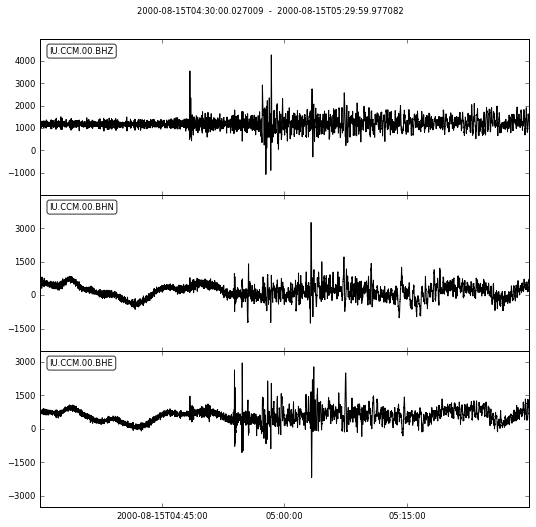

In [2]:
# Get waveforms of event plotted in my G3,2014 paper 
# (I discovered that I got the event time wrong in the paper -- but this is correct.)

from obspy.clients.fdsn import Client
client = Client("IRIS")
from obspy import UTCDateTime
t = UTCDateTime("2000-08-15T04:30:0.000")
st = client.get_waveforms("IU", "CCM", "00", "BH?", t, t + 60 * 60,attach_response=True)
st.plot() 

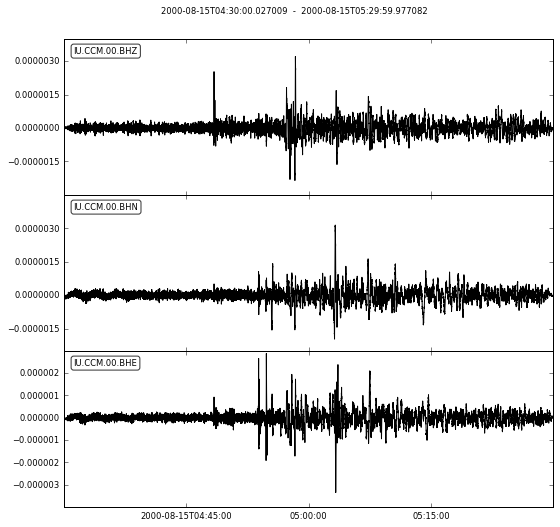

In [3]:
# remove instrument response
# dat = st.filter('bandpass',freqmin=0.02,freqmax=0.3)
pre_filt = (0.005, 0.006, 30.0, 35.0)
dat = st.copy()
dat.remove_response(pre_filt=pre_filt)
dat.plot()

In [4]:
# get event information
lat=-31.56
lon=179.74
# server does not accept longitude greater than 180.
cat = client.get_events(starttime=t-60,endtime=t+60,minlatitude=lat-1,
                  maxlatitude=lat+1,minlongitude=lon-1,maxlongitude=180)
evtime = cat.events[0].origins[0].time
evdepth = cat.events[0].origins[0].depth/1000
evlat = cat.events[0].origins[0].latitude
evlon = cat.events[0].origins[0].longitude

# station information
inventory = client.get_stations(network="IU",station="CCM",starttime=t-60,endtime=t+60)
stlat = inventory[0][0].latitude
stlon = inventory[0][0].longitude

In [5]:
# find arrival times
from obspy.taup import TauPyModel
model = TauPyModel('iasp91')
arrivals = model.get_travel_times_geo(evdepth,evlat,evlon,stlat,stlon,phase_list=['SKS'])
skstime = evtime + arrivals[0].time

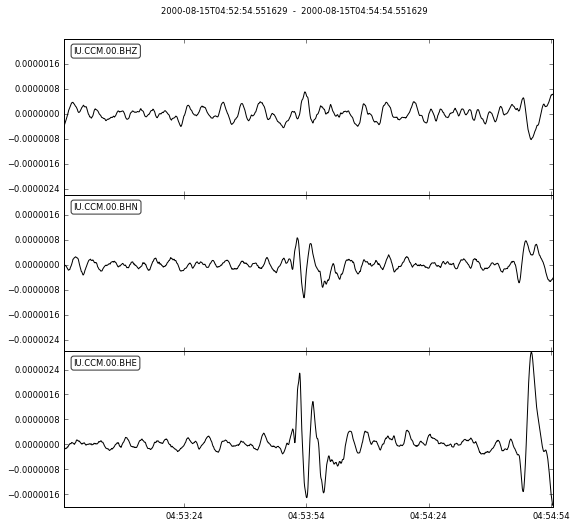

In [6]:
stf = dat.copy()
stf.filter("bandpass",freqmin=0.01,freqmax=5.0)
stf.plot(starttime=skstime-60,endtime=skstime+60)

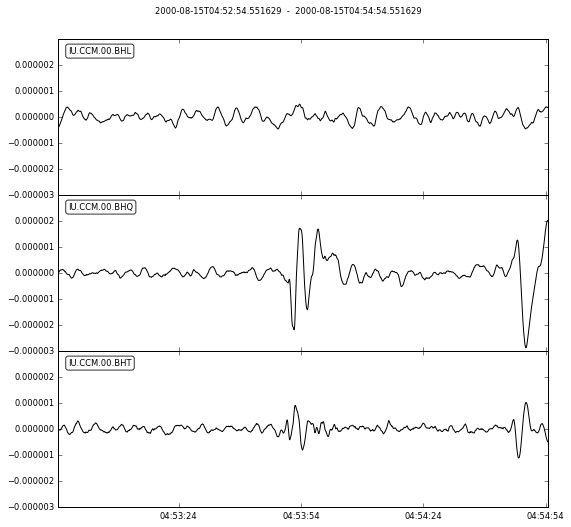

In [7]:
from obspy import geodetics
dist,az,baz = geodetics.base.gps2dist_azimuth(evlat,evlon,stlat,stlon)
inc = arrivals[0].incident_angle
# LQT Traces
stlqt = stf.copy()
stlqt.rotate('ZNE->LQT',back_azimuth=baz,inclination=inc)
stlqt.plot(starttime=skstime-60,endtime=skstime+60)


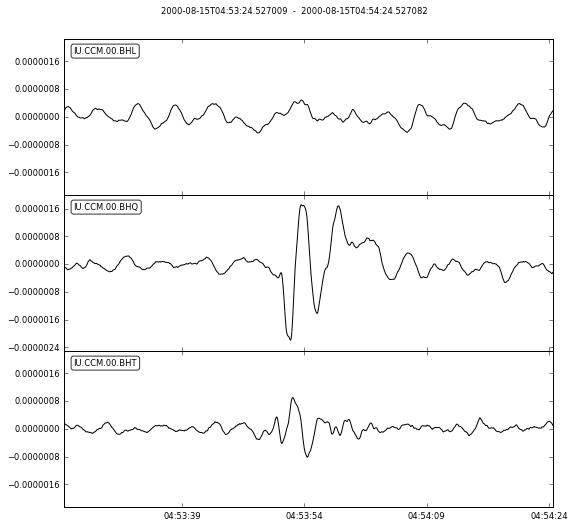

In [8]:
d = stlqt.copy()
d.trim(skstime-30,skstime+30)
d.plot()

In [9]:
delta = d[0].stats.delta
p = s.Pair(d[0].data,d[1].data,delta=delta)

In [10]:
M = s.EigenM(p)

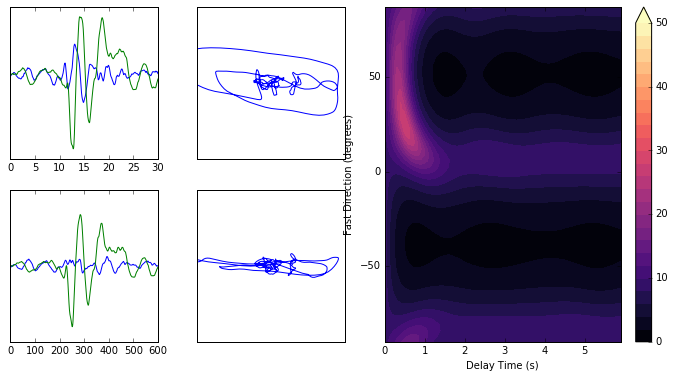

In [11]:
M.plot()

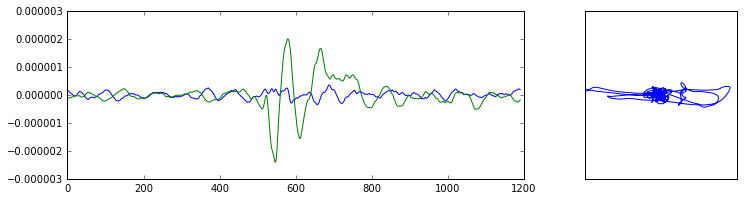

In [12]:
M.data_corr.plot()

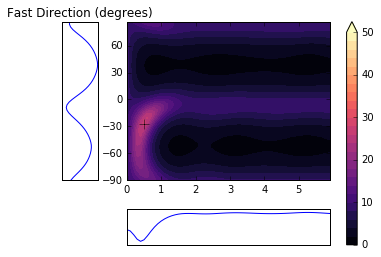

In [13]:
# Radial-Transverse Traces
strt = stf.select(component="[N,E]").copy()
strt.rotate("NE->RT",back_azimuth=baz)
# strt.plot()
e = strt.copy()
e.trim(skstime-30,skstime+30)
# e.plot()
q = s.Pair(e[0].data,e[1].data,delta=delta)
N = s.EigenM(q)
N.plotsurf(cmap='magma')

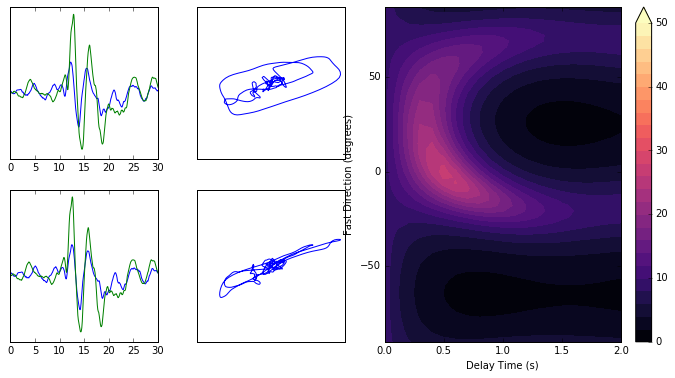

In [14]:
stne = stf.select(component="[E,N]").copy()
stne.trim(skstime-30,skstime+30)
delta = stne[0].stats.delta

tlags = np.linspace(0,2,40)
# degs = np.linspace(-90,90,90)
M = s.EigenM(stne[1].data,stne[0].data,delta=delta,tlags=tlags)
# M = s.EigenM(stne[1],stne[0],delta=delta)
M.plot()

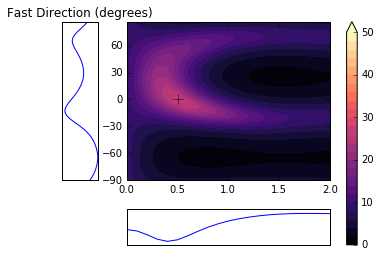

In [15]:
M.plotsurf()

In [16]:
t = s.Trio(d[0].data,d[1].data,d[2].data,delta=delta)

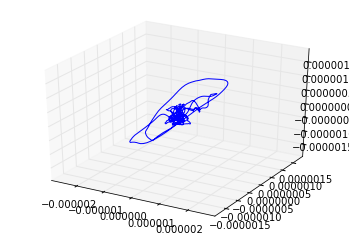

In [20]:
t.ppm()

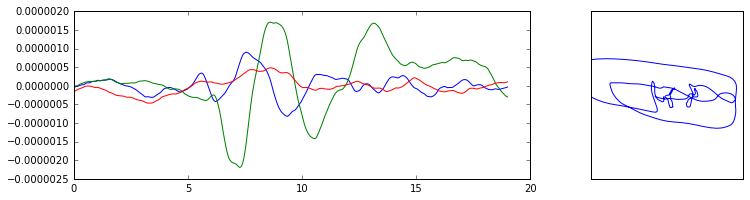

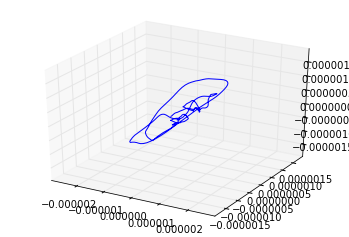

In [27]:
w = t.genwindow(30,19)
tc = t.copy()
tc.chop(w)
tc.plot()
tc.ppm()

In [ ]:
p = s.Pair()

In [ ]:
p.window?